model loaded
Episode 0# Score: 130
nice game!
Episode 1# Score: 140
nice game!
Episode 2# Score: 51
Episode 3# Score: 167
nice game!
Episode 4# Score: 67
Episode 5# Score: 76

---part1 Exploration_Rate : 0.08847 ---
---part1 Average_Score : 100.2 ---

Episode 6# Score: 82
Episode 7# Score: 199
nice game!
Episode 8# Score: 184
nice game!
Episode 9# Score: 58
Episode 10# Score: 76

---part2 Exploration_Rate : 0.07828 ---
---part2 Average_Score : 119.8 ---

Episode 11# Score: 184
nice game!
Episode 12# Score: 84
Episode 13# Score: 48
Episode 14# Score: 45
Episode 15# Score: 65

---part3 Exploration_Rate : 0.06648 ---
---part3 Average_Score : 85.2 ---

Episode 16# Score: 105
Episode 17# Score: 62
Episode 18# Score: 81
Episode 19# Score: 85
Episode 20# Score: 108

---part4 Exploration_Rate : 0.05421 ---
---part4 Average_Score : 88.2 ---

Episode 21# Score: 140
Episode 22# Score: 54
Episode 23# Score: 46
Episode 24# Score: 59
Episode 25# Score: 40

---part5 Exploration_Rate : 0.0442 ---
---p

KeyboardInterrupt: 

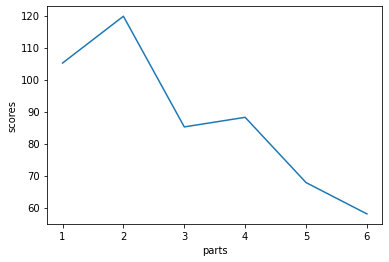

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
from matplotlib import font_manager, rc

import gym
import random
import os
import numpy as np
from collections      import deque
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense
from tensorflow.keras.optimizers import Adam

class Agent():
    def __init__(self, state_size, action_size):
        self.weight_backup      = "cartpole_weight.h5" # "cartpole_human_play.h5"
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=1000)
        self.learning_rate      = 0.001
        self.gamma              = 0.9
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.96
        self.brain              = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        

        if os.path.isfile(self.weight_backup):
            model.load_weights(self.weight_backup)
            self.exploration_rate = self.exploration_min
        
        print('model loaded')
        return model

    def save_model(self):
            self.brain.save(self.weight_backup)

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done): # 상태를 저장
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size, index, max_cnt):
        if len(self.memory) < sample_batch_size: # sample_batch_size 마다 했던 게임들을 바탕으로 학습
            return
        
        # 잘한게임 혹은 못한 게임은 그 게임을 복기
        if (index >= max_cnt * 0.9 or index >= 200) or (index < max_cnt * 0.1):
            if index >= max_cnt * 0.9 or index >= 200 :
                print('nice game!')
            else :
                print('bad game...')
            for state, action, reward, next_state, done in list(self.memory)[-index:]:
                target = reward 
                if not done: #게임 끝이 아니라면 (진행중인경우)
                    target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0]) # 큐함수
                target_f = self.brain.predict(state) # 예측값

                target_f[0][action] = target # 예측 행동의 q값을 (보상+다음상황에서의 )

                self.brain.fit(state,target_f, epochs=2, verbose=0)
                return
                   
        elif index < max_cnt * 0.1 :
            print('bad game...')
            
            sample_batch = random.sample(list(self.memory)[:-index], sample_batch_size) # 일부를 선택
            for state, action, reward, next_state, done in sample_batch:
                target = reward 
                if not done: #게임 끝이 아니라면 (진행중인경우)
                    target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0]) # 큐함수
                    
                target_f = self.brain.predict(state) # 예측값
                target_f[0][action] = target # 예측 행동의 q값을 (보상+다음상황에서의 )
                self.brain.fit(state,target_f, epochs=1, verbose=0)
                
                return
            
        # 일반 게임
        sample_batch = random.sample(self.memory, sample_batch_size) # 일부를 선택

        X_lst = []
        y_lst = []
        for state, action, reward, next_state, done in sample_batch:
            target = reward 
            if not done: #게임 끝이 아니라면 (진행중인경우)
                target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0]) # 큐함수
            target_f = self.brain.predict(state) # 예측값

            target_f[0][action] = target # 예측 행동의 q값을 (보상+다음상황에서의 )
            X_lst.append(state)
            y_lst.append(target_f)

            self.brain.fit(state,target_f, epochs=1, verbose=0)
                
        # decay
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

class CartPole:
    def __init__(self):
        self.sample_batch_size = 32
        self.episodes          = 500
        self.env               = gym.make('CartPole-v1')

        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        self.agent             = Agent(self.state_size, self.action_size)

    

    def run(self):
        
        record = {'parts' : [], 'epi' : [], 'scores' : []}
        part = 0
        max_cnt = 0
        
        try:
            for index_episode in range(self.episodes): # 총 게임 수 마다
                state = self.env.reset()[0] # 환경을 리셋 (막대를 초기 상태로)
                state = np.reshape(state, [1, self.state_size]) # 입력 데이터 양식에 맞게 변경

                done = False
                index = 0
                while not done:
                    #self.env.render()
                    
                    action = self.agent.act(state) # 시작
                    
                    next_state, reward, done, _ = self.env.step(action)[:-1] # 바로 다음 상태 
                    reward = reward if not done or index == 500 else -100
                    
                    next_state = np.reshape(next_state, [1, self.state_size]) # 다음 상태를 다시 입력 데이터 양식으로
                    
                    self.agent.remember(state, action, reward, next_state, done) # 결과를 저장
                    
                    state = next_state
                    index += 1
                    
                print("Episode {}# Score: {}".format(index_episode, index + 1))
                
                if index > max_cnt :
                    max_cnt = index
                self.agent.replay(self.sample_batch_size, index, max_cnt) # 매 에피소드마다 sample_batch_size 개수만큼 신경망 학습
                
                record['parts'].append(part+1) ; record['epi'].append(index_episode+1) ; record['scores'].append(index+1) ;
                
                if index_episode % 5 == 0 and index_episode != 0 :
                    part += 1
                    print(f'\n---part{part} Exploration_Rate : {round(self.agent.exploration_rate,5)} ---')
                    avgs = np.mean(record['scores'][-5:])
                    print(f'---part{part} Average_Score : {avgs} ---\n')
                    if avgs >= 400 :
                        print('agent reaches target-level!')
                        break
                        
        finally:
            self.agent.save_model()
            print('saved model')
            
            vis = pd.DataFrame(data = record).groupby('parts').mean().reset_index()
            print(vis)
            sns.lineplot(data = vis, x = 'parts', y= 'scores')
            

if __name__ == "__main__":
    cartpole = CartPole()
    cartpole.run()

In [12]:
# The typical imports
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [23]:
class CartPole:
    def __init__(self):
        self.sample_batch_size = 32
        self.episodes          = 1
        self.env               = gym.make('CartPole-v1',render_mode="rgb_array")

        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        self.agent             = Agent(self.state_size, self.action_size)

    

    def run(self):
        
        
        state = self.env.reset()[0] # 환경을 리셋 (막대를 초기 상태로)
        state = np.reshape(state, [1, self.state_size]) # 입력 데이터 양식에 맞게 변
        done = False
        index = 0
        frames = []
        while not done:
            #self.env.render()
            
            action = self.agent.act(state) # 시작
            
            frames.append(self.env.render())
            
            next_state, reward, done, _ = self.env.step(action)[:-1] # 바로 다음 상태 
            reward = reward if not done or index == 500 else -100
            
            next_state = np.reshape(next_state, [1, self.state_size]) # 다음 상태를 다시 입력 데이터 양식으로
            
            state = next_state
            index += 1
        self.env.close()
        display_frames_as_gif(frames)
            
            

if __name__ == "__main__":
    cartpole = CartPole()
    cartpole.run()

model loaded
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

TypeError: setup() got an unexpected keyword argument 'clear_temp'

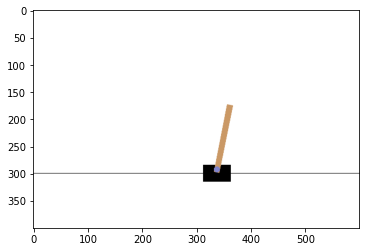

75 done


In [38]:
from IPython.display import clear_output


class CartPole:
    def __init__(self):
        self.sample_batch_size = 32
        self.episodes          = 1
        self.env               = gym.make('CartPole-v1',render_mode="rgb_array")

        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        self.agent             = Agent(self.state_size, self.action_size)

    

    def run(self):
        
        
        state = self.env.reset()[0] # 환경을 리셋 (막대를 초기 상태로)
        state = np.reshape(state, [1, self.state_size]) # 입력 데이터 양식에 맞게 변
        done = False
        index = 0
        frames = []
        while not done:
            #self.env.render()
            
            action = self.agent.act(state) # 시작
            
            clear_output(wait=True)
            plt.imshow( self.env.render())
            plt.show()
            
            next_state, reward, done, _ = self.env.step(action)[:-1] # 바로 다음 상태 
            reward = reward if not done or index == 500 else -100
            
            next_state = np.reshape(next_state, [1, self.state_size]) # 다음 상태를 다시 입력 데이터 양식으로
            
            state = next_state
            index += 1
        self.env.close()
        print(index, 'done')
            
            

if __name__ == "__main__":
    cartpole = CartPole()
    cartpole.run()



In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

In [138]:
episodes = 10
memory_que = deque(maxlen=1000)

model = Sequential()
model.add(Dense(24, input_dim=4, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer=Adam(lr=0.001))
        
class CartPole:
    def __init__(self):
        self.episodes          = 3
        self.env               = gym.make('CartPole-v1')

        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        
    def run(self):
        for index_episode in range(self.episodes): # 총 게임 수 마다
            state = self.env.reset() # 환경을 리셋 (막대를 초기 상태로)
            state = np.reshape(state, [1, self.state_size]) # 입력 데이터 양식에 맞게
            done = False
            index = 0
            while not done:
                #self.env.render()
                print(state)

                action = int(input('enter order'))
                next_state, reward, done, _ = self.env.step(action) # 바로 다음 상태 
                reward = reward if not done or index == 500 else -1

                next_state = np.reshape(next_state, [1, self.state_size]) # 다음 상태를 다시 입력 데이터 양식으로
                memory_que.append((state, action, reward, next_state, done)) # 결과를 저장
                state = next_state
                index += 1
            print(index_episode, 'is over')

        print('take it to model')

        
        X_lst = []
        y_lst = []
        for state, action, reward, next_state, done in list(memory_que):
            target = reward 
            
            target_f = np.array([[0,0]])
            target_f[0][action] = reward * index * 0.5
            X_lst.append(state)
            y_lst.append(target_f)
            print(target_f)
            
        print(len(X_lst))
        model.fit(np.asarray(X_lst),np.asarray(y_lst), epochs=10, verbose=1)
        print('done')

In [139]:
cartpole = CartPole()
print(cartpole.state_size, cartpole.action_size)
cartpole.run()

4 2
[[ 0.02559521  0.02045389 -0.0460665  -0.01071396]]


enter order 0


[[ 0.02600429 -0.17397816 -0.04628078  0.26708597]]


enter order 1


[[ 0.02252473  0.02177269 -0.04093906 -0.03982762]]


enter order 0


[[ 0.02296018 -0.17273901 -0.04173562  0.23966275]]


enter order 1


[[ 0.0195054   0.02295353 -0.03694236 -0.06588715]]


enter order 0


[[ 0.01996447 -0.17161983 -0.0382601   0.21491517]]


enter order 1


[[ 0.01653208  0.02402762 -0.0339618  -0.08958697]]


enter order 0


[[ 0.01701263 -0.17059149 -0.03575354  0.19219051]]


enter order 1


[[ 0.0136008   0.0250232  -0.03190973 -0.11155331]]


enter order 0


[[ 0.01410126 -0.16962732 -0.0341408   0.17089397]]


enter order 1


[[ 0.01070872  0.02596623 -0.03072292 -0.13236083]]


enter order 0


[[ 0.01122804 -0.16870247 -0.03337013  0.1504733 ]]


enter order 0


[[ 0.00785399 -0.36333108 -0.03036067  0.4324447 ]]


enter order 1


[[ 0.00058737 -0.16779271 -0.02171177  0.13034762]]


enter order 1


[[-0.00276848  0.02763343 -0.01910482 -0.16910525]]


enter order 0


[[-0.00221582 -0.16720992 -0.02248693  0.11748999]]


enter order 1


[[-0.00556001  0.02822688 -0.02013713 -0.18220171]]


enter order 0


[[-0.00499548 -0.16660123 -0.02378116  0.10406128]]


enter order 1


[[-0.0083275   0.02885331 -0.02169993 -0.19602863]]


enter order 0


[[-0.00775043 -0.16595162 -0.02562051  0.08973071]]


enter order 1


[[-0.01106947  0.02952801 -0.02382589 -0.21092412]]


enter order 0


[[-0.01047891 -0.16524532 -0.02804437  0.0741488 ]]


enter order 1


[[-0.01378381  0.03026722 -0.0265614  -0.22724865]]


enter order 0


[[-0.01317847 -0.16446526 -0.03110637  0.05693891]]


enter order 1


[[-0.01646777  0.03108857 -0.02996759 -0.24539374]]


enter order 0


[[-0.015846   -0.16359283 -0.03487547  0.03768809]]


enter order 1


[[-0.01911786  0.03201143 -0.03412171 -0.2657912 ]]


enter order 0


[[-0.01847763 -0.16260733 -0.03943753  0.01593717]]


enter order 1


[[-0.02172978  0.03305737 -0.03911879 -0.2889233 ]]


enter order 0


[[-0.02106863 -0.16148555 -0.04489725 -0.00883015]]


enter order 1


[[-0.02429834  0.03425057 -0.04507386 -0.3153338 ]]


enter order 0


[[-0.02361333 -0.16020131 -0.05138053 -0.03719947]]


enter order 1


[[-0.02681736  0.03561835 -0.05212452 -0.34564057]]


enter order 0


[[-0.02610499 -0.15872487 -0.05903734 -0.06983931]]


enter order 1


[[-0.02927949  0.0371916  -0.06043412 -0.38054895]]


enter order 0


[[-0.02853565 -0.15702245 -0.0680451  -0.10751653]]


enter order 1


[[-0.0316761   0.03900529 -0.07019543 -0.42086747]]


enter order 0


[[-0.030896   -0.15505552 -0.07861278 -0.15111364]]


enter order 0


[[-0.03399711 -0.34896895 -0.08163505  0.1157698 ]]


enter order 1


[[-0.04097649 -0.15277794 -0.07931966 -0.2015107 ]]


enter order 0


[[-0.04403204 -0.34668115 -0.08334987  0.0651341 ]]


enter order 1


[[-0.05096567 -0.15046923 -0.08204719 -0.25263855]]


enter order 0


[[-0.05397505 -0.3443296  -0.08709996  0.013079  ]]


enter order 1


[[-0.06086165 -0.14807351 -0.08683838 -0.30576423]]


enter order 0


[[-0.06382312 -0.34185758 -0.09295366 -0.04168183]]


enter order 1


[[-0.07066027 -0.14553411 -0.0937873  -0.36218473]]


enter order 0


[[-0.07357095 -0.3392066  -0.101031   -0.10048581]]


enter order 1


[[-0.08035509 -0.14279275 -0.10304071 -0.42325684]]


enter order 0


[[-0.08321094 -0.33631554 -0.11150584 -0.16475269]]


enter order 1


[[-0.08993725 -0.13978866 -0.1148009  -0.4904271 ]]


enter order 0


[[-0.09273302 -0.33311987 -0.12460944 -0.23601651]]


enter order 1


[[-0.09939542 -0.13645832 -0.12932977 -0.565262  ]]


enter order 0


[[-0.10212459 -0.3295513  -0.14063501 -0.31595847]]


enter order 1


[[-0.10871561 -0.13273555 -0.14695418 -0.64947796]]


enter order 0


[[-0.11137033 -0.32553795 -0.15994374 -0.40644068]]


enter order 1


[[-0.11788108 -0.12855236 -0.16807255 -0.74497086]]


enter order 0


[[-0.12045213 -0.32100555 -0.18297197 -0.5095399 ]]


enter order 0


[[-0.12687224 -0.5131422  -0.19316277 -0.27963987]]


enter order 0


[[-0.13713509 -0.7050595  -0.19875556 -0.05355524]]


enter order 0


[[-0.15123628 -0.89685893 -0.19982667  0.17042978]]


enter order 1


[[-0.16917345 -0.6995214  -0.19641808 -0.17804511]]


enter order 0


[[-0.18316388 -0.8913697  -0.19997898  0.04681773]]


enter order 1


[[-0.20099127 -0.6940259  -0.19904262 -0.3017014 ]]


enter order 0


[[-0.2148718  -0.8858369  -0.20507665 -0.07779835]]


enter order 0


[[-0.23258853 -1.077519   -0.20663261  0.14382917]]


enter order 1


[[-0.25413892 -0.88012946 -0.20375603 -0.20627537]]


enter order 0


[[-0.2717415  -1.0718435  -0.20788154  0.01585618]]


enter order 1


[[-0.29317838 -0.87444067 -0.20756441 -0.33455095]]


enter order 0


0 is over
[[-0.02598031 -0.01003139 -0.01329311 -0.0291335 ]]


enter order 0


[[-0.02618094 -0.20496021 -0.01387579  0.25932583]]


enter order 0


[[-0.03028014 -0.39988136 -0.00868927  0.54760003]]


enter order 1


[[-0.03827777 -0.20463842  0.00226273  0.25219208]]


enter order 1


[[-0.04237054 -0.00954885  0.00730657 -0.03977627]]


enter order 0


[[-0.04256152 -0.20477481  0.00651105  0.25520298]]


enter order 0


[[-0.04665701 -0.39998913  0.01161511  0.5499325 ]]


enter order 1


[[-0.05465679 -0.20503223  0.02261376  0.2609316 ]]


enter order 1


[[-0.05875744 -0.01024026  0.02783239 -0.02453375]]


enter order 0


[[-0.05896224 -0.20575006  0.02734171  0.27679905]]


enter order 0


[[-0.06307724 -0.4012512   0.03287769  0.5779786 ]]


enter order 1


[[-0.07110227 -0.2066051   0.04443727  0.29583156]]


enter order 1


[[-0.07523437 -0.0121439   0.0503539   0.01748795]]


enter order 0


[[-0.07547725 -0.20795047  0.05070366  0.3256233 ]]


enter order 0


[[-0.07963626 -0.4037563   0.05721612  0.6338551 ]]


enter order 0


[[-0.08771139 -0.59962773  0.06989323  0.9439938 ]]


enter order 1


[[-0.09970394 -0.40551347  0.0887731   0.6740652 ]]


enter order 1


[[-0.10781421 -0.21173011  0.10225441  0.4105998 ]]


enter order 1


[[-0.11204881 -0.0181952   0.1104664   0.15182424]]


enter order 0


[[-0.11241271 -0.21471131  0.11350289  0.47721282]]


enter order 0


[[-0.11670694 -0.41123748  0.12304714  0.8034035 ]]


enter order 1


[[-0.12493169 -0.21799816  0.13911521  0.5518207 ]]


enter order 1


[[-0.12929165 -0.02507593  0.15015163  0.30600113]]


enter order 0


[[-0.12979317 -0.22198299  0.15627165  0.6420173 ]]


enter order 0


[[-0.13423283 -0.4188982   0.169112    0.979548  ]]


enter order 1


[[-0.1426108  -0.22639704  0.18870296  0.74439764]]


enter order 1


[[-0.14713873 -0.03431073  0.20359091  0.51653296]]


enter order 1


1 is over
[[ 0.02250875 -0.00243476  0.04303031  0.01282795]]


enter order 1


[[ 0.02246005  0.19204451  0.04328687 -0.26597393]]


enter order 0


[[ 0.02630094 -0.00366766  0.0379674   0.04004171]]


enter order 1


[[ 0.02622759  0.19088985  0.03876823 -0.2404245 ]]


enter order 0


[[ 0.03004538 -0.00476384  0.03395974  0.06423052]]


enter order 1


[[ 0.02995011  0.18985517  0.03524435 -0.21754743]]


enter order 0


[[ 0.03374721 -0.00575242  0.0308934   0.08604144]]


enter order 0


[[ 0.03363216 -0.20130327  0.03261423  0.38830897]]


enter order 1


[[ 0.0296061  -0.00665907  0.04038041  0.10608481]]


enter order 1


[[ 0.02947292  0.18786164  0.04250211 -0.1735898 ]]


enter order 1


[[ 0.03323015  0.38235036  0.03903031 -0.45256752]]


enter order 0


[[ 0.04087716  0.18669881  0.02997896 -0.14784172]]


enter order 1


[[ 0.04461113  0.38137892  0.02702212 -0.4309182 ]]


enter order 0


[[ 0.05223871  0.18588495  0.01840376 -0.12984076]]


enter order 0


[[ 0.05595641 -0.00949574  0.01580695  0.16859104]]


enter order 1


[[ 0.05576649  0.18539643  0.01917877 -0.11906365]]


enter order 0


[[ 0.05947442 -0.00999498  0.01679749  0.17960778]]


enter order 1


[[ 0.05927452  0.18488263  0.02038965 -0.10772915]]


enter order 1


[[ 0.06297217  0.37970653  0.01823507 -0.39391014]]


enter order 0


[[ 0.0705663   0.18433064  0.01035686 -0.09553421]]


enter order 0


[[ 0.07425292 -0.0109382   0.00844618  0.20039822]]


enter order 1


[[ 0.07403415  0.18406193  0.01245414 -0.08960841]]


enter order 0


[[ 0.0777154  -0.01123629  0.01066198  0.20697764]]


enter order 1


[[ 0.07749067  0.18373159  0.01480153 -0.08232299]]


enter order 1


[[ 0.0811653   0.37863827  0.01315507 -0.3702995 ]]


enter order 0


[[ 0.08873807  0.1833319   0.00574908 -0.07349783]]


enter order 0


[[ 0.0924047  -0.01187199  0.00427912  0.2209934 ]]


enter order 0


[[ 0.09216727 -0.20705484  0.00869899  0.51502305]]


enter order 1


[[ 0.08802617 -0.01205647  0.01899945  0.22509404]]


enter order 1


[[ 0.08778504  0.18278886  0.02350133 -0.06153571]]


enter order 0


[[ 0.09144081 -0.01266203  0.02227062  0.23846842]]


enter order 1


[[ 0.09118757  0.1821348   0.02703999 -0.04710735]]


enter order 1


[[ 0.09483027  0.3768588   0.02609784 -0.33113778]]


enter order 0


[[ 0.10236745  0.18137527  0.01947508 -0.03034044]]


enter order 1


[[ 0.10599495  0.3762126   0.01886827 -0.3168157 ]]


enter order 1


[[ 0.11351921  0.5710608   0.01253196 -0.60348904]]


enter order 0


[[ 0.12494042  0.37576583  0.00046218 -0.30688527]]


enter order 0


[[ 0.13245574  0.18063729 -0.00567553 -0.01405662]]


enter order 0


[[ 0.13606848 -0.01440281 -0.00595666  0.27683023]]


enter order 1


[[ 0.13578042  0.18080361 -0.00042005 -0.01772547]]


enter order 0


[[ 0.1393965  -0.01431231 -0.00077456  0.2748249 ]]


enter order 1


[[ 0.13911025  0.18082067  0.00472193 -0.01810223]]


enter order 0


[[ 0.14272666 -0.01436867  0.00435989  0.27606678]]


enter order 1


[[ 0.14243929  0.18069081  0.00988123 -0.01523786]]


enter order 0


[[ 0.1460531  -0.01457145  0.00957647  0.28054625]]


enter order 1


[[ 0.14576168  0.1804126   0.01518739 -0.00910096]]


enter order 1


[[ 0.14936993  0.3753135   0.01500537 -0.29695365]]


enter order 0


[[0.1568762  0.17998087 0.0090663  0.00042369]]


enter order 0


[[ 0.16047582 -0.01526992  0.00907477  0.2959533 ]]


enter order 1


[[0.16017042 0.17972149 0.01499384 0.00614617]]


enter order 1


[[ 0.16376485  0.37462524  0.01511676 -0.28176856]]


enter order 0


[[0.17125735 0.17929097 0.00948139 0.01564354]]


enter order 1


[[ 0.17484318  0.37427565  0.00979426 -0.2740329 ]]


enter order 0


[[0.18232869 0.17901535 0.00431361 0.02172302]]


enter order 1


[[ 0.18590899  0.37407517  0.00474807 -0.2695958 ]]


enter order 0


[[ 0.1933905   0.17888579 -0.00064385  0.0245809 ]]


enter order 1


[[ 1.9696821e-01  3.7401697e-01 -1.5223179e-04 -2.6830509e-01]]


enter order 0


[[ 0.20444855  0.17889719 -0.00551833  0.02432981]]


enter order 1


[[ 0.2080265   0.37409782 -0.00503174 -0.2700891 ]]


enter order 0


[[ 0.21550845  0.17904805 -0.01043352  0.02100256]]


enter order 1


[[ 0.21908942  0.37431806 -0.01001347 -0.2749539 ]]


enter order 0


[[ 0.22657578  0.1793404  -0.01551255  0.014554  ]]


enter order 0


[[ 0.23016258 -0.01555568 -0.01522147  0.30230245]]


enter order 0


[[ 0.22985147 -0.21045743 -0.00917542  0.59014624]]


enter order 1


[[ 0.22564232 -0.01520821  0.00262751  0.29458722]]


enter order 1


[[0.22533816 0.17987618 0.00851925 0.00273414]]


enter order 1


[[ 0.22893567  0.37487492  0.00857394 -0.28724873]]


enter order 0


[[0.23643318 0.17963175 0.00282896 0.00812596]]


enter order 0


[[ 0.24002582 -0.01553065  0.00299148  0.30170012]]


enter order 1


[[0.2397152  0.17954853 0.00902548 0.00996214]]


enter order 1


[[ 0.24330617  0.37453988  0.00922472 -0.27985954]]


enter order 0


[[0.25079697 0.17928758 0.00362753 0.01571851]]


enter order 0


[[ 0.25438273 -0.01588621  0.0039419   0.30954376]]


enter order 1


[[0.254065   0.17917936 0.01013278 0.0181066 ]]


enter order 1


[[ 0.2576486   0.37415454  0.01049491 -0.27136216]]


enter order 0


[[0.26513168 0.17888442 0.00506767 0.02461233]]


enter order 0


[[ 0.26870936 -0.01630985  0.00555991  0.31888986]]


enter order 1


[[0.26838318 0.17873248 0.01193771 0.02796549]]


enter order 1


[[ 0.2719578   0.37368122  0.01249702 -0.26092717]]


enter order 0


[[0.27943143 0.17838313 0.00727848 0.03567112]]


enter order 0


[[ 0.2829991  -0.01684244  0.0079919   0.33064157]]


enter order 1


[[0.28266224 0.17816484 0.01460473 0.04048958]]


enter order 1


[[ 0.28622556  0.37307435  0.01541452 -0.24754988]]


enter order 0


[[0.29368705 0.17773569 0.01046353 0.04995501]]


enter order 0


[[ 0.29724175 -0.01753473  0.01146263  0.3459208 ]]


enter order 1


[[0.29689106 0.17742231 0.01838104 0.05687441]]


enter order 1


[[ 0.3004395   0.37227595  0.01951853 -0.22995296]]


enter order 0


[[0.30788502 0.1768806  0.01491947 0.06882232]]


enter order 1


[[ 0.31142265  0.37178552  0.01629592 -0.21911635]]


enter order 0


[[0.31885836 0.17643446 0.01191359 0.07866213]]


enter order 1


[[ 0.32238704  0.3713836   0.01348683 -0.21023835]]


enter order 0


[[0.3298147  0.17607144 0.00928207 0.08666827]]


enter order 1


[[ 0.33333614  0.37105912  0.01101543 -0.20307176]]


enter order 0


[[0.3407573  0.17578138 0.006954   0.09306554]]


enter order 1


[[ 0.34427294  0.37080297  0.00881531 -0.1974153 ]]


enter order 0


[[0.351689   0.17555605 0.004867   0.09803537]]


enter order 1


[[ 0.3552001   0.3706079   0.00682771 -0.19310807]]


enter order 0


[[0.36261228 0.17538896 0.00296555 0.10172087]]


enter order 0


[[ 0.36612007 -0.01977537  0.00499996  0.39533794]]


enter order 1


[[0.36572456 0.17527528 0.01290672 0.1042356 ]]


enter order 1


[[ 0.36923006  0.3702099   0.01499144 -0.18434753]]


enter order 0


[[0.37663427 0.1748767  0.01130448 0.11302669]]


enter order 0


[[ 0.38013178 -0.02040539  0.01356502  0.40925455]]


enter order 1


[[0.3797237  0.17452164 0.02175011 0.12087891]]


enter order 0


[[ 0.38321412 -0.02090507  0.02416769  0.42034367]]


enter order 1


[[0.38279602 0.17386626 0.03257456 0.1353766 ]]


enter order 1


[[ 0.38627335  0.36850685  0.03528209 -0.14685418]]


enter order 0


[[0.39364347 0.17289788 0.03234501 0.15674748]]


enter order 0


[[ 0.39710143 -0.02267189  0.03547996  0.45945644]]


enter order 1


[[0.396648   0.17193104 0.04466909 0.17816468]]


enter order 1


[[ 0.4000866   0.36638623  0.04823238 -0.10009881]]


enter order 0


[[0.40741435 0.1706074  0.04623041 0.20740274]]


enter order 0


[[ 0.4108265  -0.02514408  0.05037846  0.51430315]]


enter order 1


[[0.41032362 0.16923352 0.06066452 0.23791166]]


enter order 1


[[ 0.41370827  0.3634387   0.06542276 -0.03503581]]


enter order 0


[[0.42097706 0.16744253 0.06472204 0.27755007]]


enter order 0


[[ 0.4243259  -0.02854018  0.07027304  0.5899236 ]]


enter order 1


[[0.4237551  0.1655311  0.08207151 0.32017848]]


enter order 0


[[ 0.42706573 -0.03065793  0.08847509  0.6375734 ]]


enter order 1


[[0.42645258 0.16312611 0.10122655 0.37401205]]


enter order 1


[[0.4297151  0.3566754  0.10870679 0.11488412]]


enter order 1


[[ 0.43684858  0.5500854   0.11100447 -0.14162153]]


enter order 0


[[0.44785032 0.35356316 0.10817204 0.18391588]]


enter order 1


[[ 0.45492157  0.54698443  0.11185036 -0.07277966]]


enter order 0


[[0.46586126 0.35045147 0.11039477 0.25299317]]


enter order 0


[[0.4728703  0.15394053 0.11545463 0.57835543]]


enter order 0


[[ 0.47594908 -0.04259411  0.12702174  0.90506303]]


enter order 1


[[0.4750972  0.15060008 0.145123   0.6548505 ]]


enter order 1


[[0.4781092  0.3434353  0.15822001 0.4111548 ]]


enter order 1


[[0.48497793 0.536002   0.16644311 0.17223553]]


enter order 1


[[ 0.49569795  0.7283991   0.16988781 -0.06366322]]


enter order 1


[[ 0.51026595  0.92072964  0.16861455 -0.29829863]]


enter order 0


[[0.52868056 0.72365576 0.16264857 0.04245803]]


enter order 1


[[ 0.54315364  0.916117    0.16349775 -0.19481555]]


enter order 1


[[ 0.561476    1.1085687   0.15960144 -0.43178877]]


enter order 0


[[ 0.5836474   0.91158944  0.15096565 -0.09335122]]


enter order 0


[[0.6018792  0.7146623  0.14909863 0.24289523]]


enter order 0


[[0.6161724  0.5177601  0.15395653 0.5786445 ]]


enter order 1


[[0.6265276  0.7104274  0.16552943 0.33814648]]


enter order 1


[[0.64073616 0.9028546  0.17229235 0.10189468]]


enter order 0


[[0.6587932  0.70573604 0.17433025 0.4435986 ]]


enter order 0


[[0.67290795 0.50863147 0.18320222 0.78576803]]


enter order 0


[[0.6830806  0.31152892 0.19891758 1.1300348 ]]


enter order 1


2 is over
take it to model
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[71  0]]
[[ 0 71]]
[[-71   0]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[ 0 71]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[ 0 71]]
[[71  0]]
[[71  0]]
[[ 0 71]]
[[ 0 71]]
[[  0 -71]]
[[ 0 71]]
[[71  0]]

In [136]:
model.save('cartpole_human_play.h5')

In [51]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # 할인율
        self.epsilon = 1.0  # 탐욕적 행동 선택을 위한 탐사 비율
        self.epsilon_decay = 0.99  # 탐사 비율의 감소율
        self.epsilon_min = 0.005  # 탐사 비율의 최소값
        self.learning_rate = 0.005  # 학습률
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [52]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
batch_size = 32
num_episodes = 400
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

for episode in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    time = 0
    while not done:
        #env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done or time == 499 else -100
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        time += 1
        if done:
            print(f"Episode: {episode+1}, Score: {time}")
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
           

Episode: 1, Score: 13
Episode: 2, Score: 20
Episode: 3, Score: 14
Episode: 4, Score: 36
Episode: 5, Score: 15
Episode: 6, Score: 11
Episode: 7, Score: 12
Episode: 8, Score: 19


KeyboardInterrupt: 

In [48]:
import tensorflow as tf

In [49]:
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        self.actor = self.build_actor()
        self.critic = self.build_critic()

    def build_actor(self):
        input_state = Input(shape=(self.state_size,))
        shared = Dense(24, activation='relu')(input_state)
        shared = Dense(24, activation='relu')(shared)
        action_prob = Dense(self.action_size, activation='softmax')(shared)

        actor = Model(inputs=input_state, outputs=action_prob)
        actor.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')
        return actor

    def build_critic(self):
        input_state = Input(shape=(self.state_size,))
        shared = Dense(24, activation='relu')(input_state)
        shared = Dense(24, activation='relu')(shared)
        value = Dense(self.value_size, activation='linear')(shared)

        critic = Model(inputs=input_state, outputs=value)
        critic.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return critic

    def get_action(self, state):
        state = np.expand_dims(state, axis=0)
        action_probs = self.actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=action_probs)
        return action

    def train(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)
        target = reward + (1 - done) * self.critic.predict(next_state)

        advantages = target - self.critic.predict(state)
        action_one_hot = tf.one_hot([action], self.action_size, dtype=tf.float32)

        self.actor.fit(state, action_one_hot, sample_weight=advantages, verbose=0)
        self.critic.fit(state, target, verbose=0)


In [50]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = A2CAgent(state_size, action_size)
num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.train(state, action, reward, next_state, done)
        state = next_state
        score += reward

    print(f"Episode: {episode+1}, Score: {score}")


Episode: 1, Score: 15.0
Episode: 2, Score: 47.0
Episode: 3, Score: 69.0
Episode: 4, Score: 33.0
Episode: 5, Score: 25.0
Episode: 6, Score: 18.0
Episode: 7, Score: 26.0
Episode: 8, Score: 9.0
Episode: 9, Score: 10.0
Episode: 10, Score: 24.0
Episode: 11, Score: 18.0
Episode: 12, Score: 25.0
Episode: 13, Score: 10.0
Episode: 14, Score: 21.0
Episode: 15, Score: 11.0
Episode: 16, Score: 17.0
Episode: 17, Score: 9.0
Episode: 18, Score: 10.0
Episode: 19, Score: 12.0
Episode: 20, Score: 12.0
Episode: 21, Score: 17.0
Episode: 22, Score: 8.0
Episode: 23, Score: 9.0
Episode: 24, Score: 10.0
Episode: 25, Score: 11.0
Episode: 26, Score: 15.0
Episode: 27, Score: 10.0
Episode: 28, Score: 9.0
Episode: 29, Score: 11.0
Episode: 30, Score: 14.0
Episode: 31, Score: 10.0
Episode: 32, Score: 24.0
Episode: 33, Score: 18.0
Episode: 34, Score: 11.0
Episode: 35, Score: 9.0
Episode: 36, Score: 8.0
Episode: 37, Score: 26.0
Episode: 38, Score: 15.0
Episode: 39, Score: 12.0
Episode: 40, Score: 10.0
Episode: 41, Sco

KeyboardInterrupt: 